<a href="https://colab.research.google.com/github/KhafillahAkbar/MachLearn_Ganjil_2023/blob/main/Week%2010/Jobsheet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab Work 1

### Setup

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Setup Input pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This typical Mamet film delivers a quiet, evenly paced insight into what makes a confidence man (Joe Mantegna) good. Explored as a psychological study by a noted psychologist (Lindsay Crouse), it slowly pulls her into his world with the usual nasty consequences. The cast includes a number of the players found is several of Mamet's films (Steven Goldstein, Jack Wallace, Ricky Jay, Andy Potok, Allen Soule, William H. Macy), and they do their usual good job. I loved Lindsay Crouse in this film, and have often wondered why she didn't become a more noted player than she has become. Perhaps I'm not looking in the right places!<br /><br />The movie proceeds at a slow pace, with flat dialog, yet it maintains a level of tension throughout which logically leads to the bang-up ending. You'd expect a real let down at the ending, but I found it uplifting and satisfying. I love this movie!"
 b'Antonioni, by making this film, had assumed the role of Papa Smurf to all the little long-haired

### Create a text Encoder

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 11, 764,   1, ...,   0,   0,   0],
       [  1,  33, 245, ...,   0,   0,   0],
       [ 10, 479,  48, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This typical Mamet film delivers a quiet, evenly paced insight into what makes a confidence man (Joe Mantegna) good. Explored as a psychological study by a noted psychologist (Lindsay Crouse), it slowly pulls her into his world with the usual nasty consequences. The cast includes a number of the players found is several of Mamet's films (Steven Goldstein, Jack Wallace, Ricky Jay, Andy Potok, Allen Soule, William H. Macy), and they do their usual good job. I loved Lindsay Crouse in this film, and have often wondered why she didn't become a more noted player than she has become. Perhaps I'm not looking in the right places!<br /><br />The movie proceeds at a slow pace, with flat dialog, yet it maintains a level of tension throughout which logically leads to the bang-up ending. You'd expect a real let down at the ending, but I found it uplifting and satisfying. I love this movie!"
Round-trip:  this typical [UNK] film [UNK] a [UNK] [UNK] [UNK] [UNK] into what makes a [UNK] man 

### Create a Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00134256]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 62ms/step
[0.00134256]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 58s 124ms/step - loss: 0.6222 - accuracy: 0.5911 - val_loss: 0.4678 - val_accuracy: 0.7812
Epoch 2/10
391/391 [==============================] - 24s 62ms/step - loss: 0.4014 - accuracy: 0.8212 - val_loss: 0.3872 - val_accuracy: 0.8464
Epoch 3/10
391/391 [==============================] - 26s 64ms/step - loss: 0.3440 - accuracy: 0.8500 - val_loss: 0.3494 - val_accuracy: 0.8370
Epoch 4/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3262 - accuracy: 0.8586 - val_loss: 0.3344 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3162 - accuracy: 0.8627 - val_loss: 0.3481 - val_accuracy: 0.8464
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3124 - accuracy: 0.8656 - val_loss: 0.3281 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3081 - accuracy: 0.8673 - val_loss: 0.3516 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3243 - accuracy: 0.8461
Test Loss: 0.3243265450000763
Test Accuracy: 0.8460800051689148


(0.0, 0.6382212951779366)

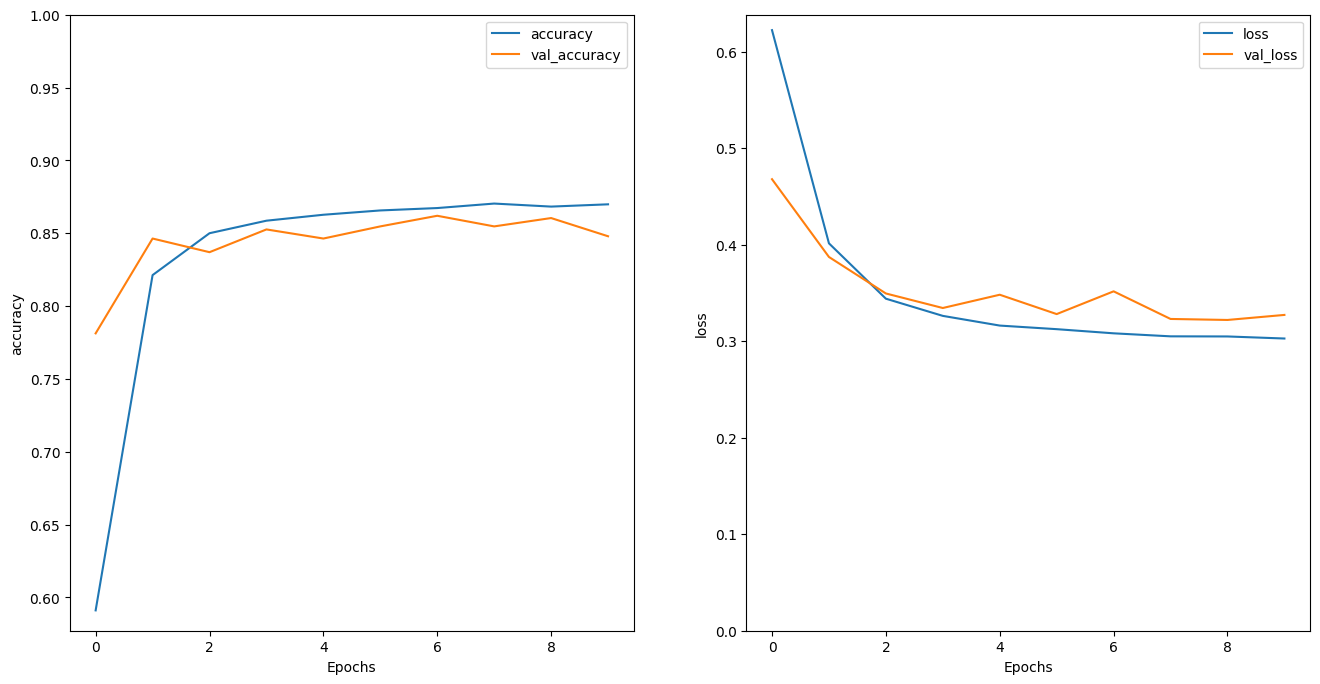

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 75s 145ms/step - loss: 0.6138 - accuracy: 0.5979 - val_loss: 0.4201 - val_accuracy: 0.7818
Epoch 2/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3751 - accuracy: 0.8349 - val_loss: 0.3416 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3338 - accuracy: 0.8555 - val_loss: 0.3277 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3155 - accuracy: 0.8647 - val_loss: 0.3207 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3123 - accuracy: 0.8666 - val_loss: 0.3178 - val_accuracy: 0.8589
Epoch 6/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3059 - accuracy: 0.8680 - val_loss: 0.3151 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 44s 113ms/step - loss: 0.2992 - accuracy: 0.8708 - val_loss: 0.3166 - val_ac

In [22]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.6906329]]


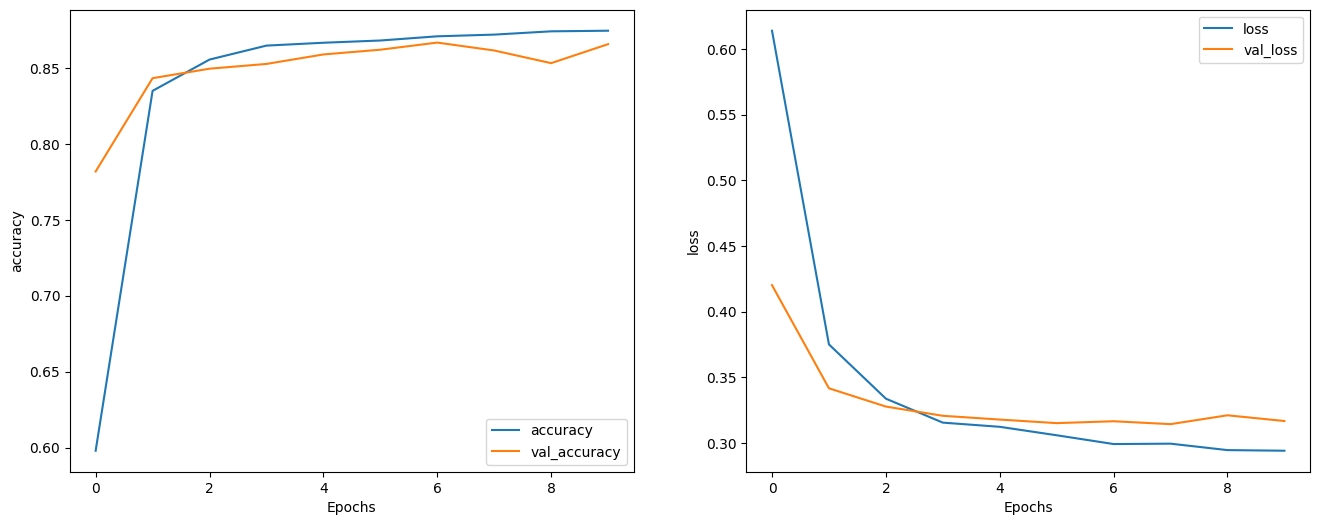

In [23]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')


## Lab Work 2

### Setup

In [24]:
import tensorflow as tf
import numpy as np
import os
import time


In [25]:
path_to_file=tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


1115394/1115394 [==============================] - 0s 0us/step


### Load data

In [26]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [27]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [28]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')


65 unique characters


### Text Processing

In [29]:
example_texts=['abcdefg','xyz']
chars=tf.strings.unicode_split(example_texts,input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [30]:
ids_from_chars=tf.keras.layers.StringLookup(vocabulary=list(vocab),mask_token=None)


In [31]:
ids=ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [32]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [33]:
chars=chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [34]:
tf.strings.reduce_join(chars,axis=-1).numpy()


array([b'abcdefg', b'xyz'], dtype=object)

### Prediction

In [35]:
all_ids=ids_from_chars(tf.strings.unicode_split(text,'UTF-8'))
all_ids


<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [36]:
ids_dataset=tf.data.Dataset.from_tensor_slices(all_ids)


In [37]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [38]:
seq_length=100


In [39]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [40]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
    return tf.strings.reduce_join(ids_from_chars(ids), axis=-1).numpy()


In [41]:
for seq in sequences.take(5):
    print(text_from_ids(seq))


b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [42]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [43]:
split_input_target(list("Tensorflow"))


(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [44]:
dataset = sequences.map(split_input_target)


In [45]:
for input_example,target_example in dataset.take(1):
    print("Input :",text_from_ids(input_example))
    print("Target:",text_from_ids(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Creating Batch Training

In [46]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### Create a model

In [47]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024


In [48]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [49]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### Test The model

In [50]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [51]:
model.summary()


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
sampled_indices=tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices=tf.squeeze(sampled_indices,axis=-1).numpy()

In [53]:
sampled_indices


array([38, 51, 57, 40,  1, 60, 51, 54, 64, 20,  4,  2, 39, 51, 46, 38, 27,
       49, 32, 20, 54,  3,  7, 49, 56, 16, 63, 27,  3, 46, 56, 23, 46, 47,
       64, 63, 29, 42, 45, 59, 65, 45, 53, 17, 40, 53, 40, 39,  8, 15, 24,
        8, 52,  2, 13, 57, 51, 54, 26, 59,  7, 30, 44, 44, 38, 42, 33, 58,
       13, 46, 48, 58,  1, 43, 21, 29, 37, 53, 28,  3, 60, 32, 45, 45, 53,
       30,  5, 57, 28, 22, 48, 48, 64,  8, 34,  3, 18, 16,  8, 36])

In [54]:
print("Input:\n",text_from_ids(input_example_batch[0]))
print()
print("Next Char Predictions:\n",text_from_ids(sampled_indices))


Input:
 b'you know the reason of this haste.\n\nFRIAR LAURENCE:\n\nPARIS:\nHappily met, my lady and my wife!\n\nJULIE'

Next Char Predictions:
 b'Ylra\nuloyG$ ZlgYNjSGo!,jqCxN!gqJghyxPcftzfnDanaZ-BK-m ?rloMt,QeeYcTs?gis\ndHPXnO!uSffnQ&rOIiiy-U!EC-W'


### Train the model

In [55]:
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True)


In [56]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)



Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.188581, shape=(), dtype=float32)


In [57]:
tf.exp(example_batch_mean_loss).numpy()


65.92918

In [58]:
model.compile(optimizer='adam',loss=loss)


### Configure Check Point

In [59]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [62]:
EPOCHS=10


In [63]:
history=model.fit(dataset,epochs=EPOCHS,callbacks=[checkpoint_callback])


Epoch 1/10
172/172 [==============================] - 12s 56ms/step - loss: 1.4213
Epoch 2/10
172/172 [==============================] - 16s 60ms/step - loss: 1.3611
Epoch 3/10
172/172 [==============================] - 14s 58ms/step - loss: 1.3128
Epoch 4/10
172/172 [==============================] - 13s 59ms/step - loss: 1.2709
Epoch 5/10
172/172 [==============================] - 13s 54ms/step - loss: 1.2317
Epoch 6/10
172/172 [==============================] - 11s 54ms/step - loss: 1.1921
Epoch 7/10
172/172 [==============================] - 11s 54ms/step - loss: 1.1521
Epoch 8/10
172/172 [==============================] - 11s 54ms/step - loss: 1.1106
Epoch 9/10
172/172 [==============================] - 11s 55ms/step - loss: 1.0657
Epoch 10/10
172/172 [==============================] - 11s 55ms/step - loss: 1.0192


### Generate Text

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


In [ ]:
one_step_model=OneStep(model,chars_from_ids,ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

## Lab ASsignment

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))
